100555297
Sunu Pious Joseph

# Assignment 3: 

[Available on Google Colaboratory](https://colab.research.google.com/drive/1QrcjfdcahcBPU3FuKMhxMGozGRzMTA3H)

## About

In this assignment, you will work with the daily weather data for the city of Madrid from 1997 - 2015.

The objective is to train a neural network that will predict various weather events including:

- Rain
- Snow
- Fog
- Thunderstorm
- Hail
- Tornado

## Submission

- You must submit via `git push`.
- You must complete running all the cells, and include the executed Jupyter notebook in the submitted commit.

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Dense, Conv2D, MaxPool2D, Flatten, LSTM, SimpleRNN
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot

# Getting the data

The data is available at the given URL.  The following code will load the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/).

If you are unfamiliar with DataFrame API, you can easily pick it up from here: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

Very minimal knowledge of DataFrame is needed, as most of the code is provided in the notebook already.

In [0]:
url = 'https://github.com/ontariotechu-csci4050u/course-material-2019/' \
      'raw/master/data/weather_madrid_LEMD_1997_2015.csv.gz'
df = pd.read_csv(url).rename(columns={"CET": "date"}).set_index('date')
df.columns = [x.strip() for x in df.columns]

This is what the dataframe `df` looks like.  Note that it has a number of numerical attributes including _temperature_, _pressure_, _visibility_, etc.

In [2010]:
df.head()

,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
date,,,,,,,,,,,,,,,,,,,,,,
1997-1-1,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229
1997-1-2,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143
1997-1-3,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256
1997-1-4,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284
1997-1-5,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2


# Building the weather event columns

We construct _binary_ columns as indicators of the key weather events that occurred during the day.

The weather conditions are:

- Rain, Snow, Fog, Thunderstorm, Hail, Tornado
- and also _NoEvent_.

They are additional columns to the dataframe.

In [0]:
event_columns = ['Rain', 'Snow', 'Fog', 'Thunderstorm', 'Hail', 'Tornado', 'NoEvent']

In [0]:
for ev in event_columns:
  if ev == 'NoEvent':
    df[ev] = df['Events'].isna()
  else:
    df[ev] = df['Events'].str.contains(ev).fillna(False)

Here is the _augmented_ dataframe.  Scroll horizontally to make sure that `df` now contains the binary indicators of each weather event.

In [2013]:
df.head()

,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Rain,Snow,Fog,Thunderstorm,Hail,Tornado,NoEvent
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997-1-1,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229,False,False,False,False,False,False,True
1997-1-2,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143,True,False,False,False,False,False,False
1997-1-3,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256,True,True,False,False,False,False,False
1997-1-4,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284,False,False,False,False,False,False,True
1997-1-5,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2,False,True,False,False,False,False,False


## Building the features

We identify the numeric columns as _observations_.  We will use these columns as input vectors to a neural network.

**Note**: Since large magnitude differences will cause serious numerical issues during gradient descent, we *always* use **normalized** vectors.  So for each numerical column, we compute the minimum and maximum values which are used to rescale the column to the range of :
`[0.0 .. 1.0]`

In [0]:
def get_normalized_features(df, columns):
  df2 = pd.DataFrame(index=df.index)
  for c in columns:
    series = df[c]
    max = series.max()
    min = series.min()
    df2[c] = (series - min) / (max - min)
  return df2

In [0]:
numeric_columns = [
       'Max TemperatureC',
       'Mean TemperatureC',
       'Min TemperatureC',
       'Dew PointC',
       'MeanDew PointC',
       'Min DewpointC',
       'Max Humidity',
       'Mean Humidity',
       'Min Humidity',
       'Max Sea Level PressurehPa',
       'Mean Sea Level PressurehPa',
       'Min Sea Level PressurehPa',
       'Max VisibilityKm',
       'Mean VisibilityKm',
       'Min VisibilitykM',
       'Max Wind SpeedKm/h',
       'Mean Wind SpeedKm/h',
       'Max Gust SpeedKm/h',
       'Precipitationmm',
       'CloudCover',
       'WindDirDegrees']

The features are the normalized observations.  We can use them in learning a model to predict weather events.

In [2016]:
features = get_normalized_features(df, numeric_columns)
features.head()

,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees
date,,,,,,,,,,,,,,,,,,,,,
1997-1-1,0.170732,0.200000,0.315789,0.53125,0.580645,0.666667,1.000000,0.941176,0.750000,0.301887,0.385965,0.513158,0.3,0.290323,0.129032,0.071429,0.153846,NaN,0.0,0.750,0.637119
1997-1-2,0.170732,0.171429,0.263158,0.56250,0.580645,0.611111,1.000000,0.905882,0.697917,0.245283,0.298246,0.421053,0.3,0.290323,0.129032,0.142857,0.205128,0.333333,0.0,0.625,0.398892
1997-1-3,0.121951,0.171429,0.315789,0.53125,0.516129,0.583333,1.000000,0.823529,0.687500,0.207547,0.228070,0.407895,0.3,0.322581,0.225806,0.148352,0.487179,NaN,0.0,0.750,0.711911
1997-1-4,0.170732,0.171429,0.236842,0.31250,0.387097,0.500000,0.833333,0.564706,0.468750,0.339623,0.421053,0.526316,0.3,0.322581,0.322581,0.148352,0.487179,0.250000,0.0,0.250,0.789474
1997-1-5,0.048780,0.085714,0.236842,0.43750,0.483871,0.527778,1.000000,0.941176,0.854167,0.339623,0.385965,0.526316,0.3,0.161290,0.032258,0.076923,0.153846,NaN,0.0,0.875,0.008310


In [2017]:
features.shape

(6812, 21)

# Building Output

The targets are 0/1 columns for each of the 

In [2018]:
targets = df[event_columns].applymap(lambda x: 1 if x else 0)
targets.head()

,Rain,Snow,Fog,Thunderstorm,Hail,Tornado,NoEvent
date,,,,,,,
1997-1-1,0,0,0,0,0,0,1
1997-1-2,1,0,0,0,0,0,0
1997-1-3,1,1,0,0,0,0,0
1997-1-4,0,0,0,0,0,0,1
1997-1-5,0,1,0,0,0,0,0


# Building the training and test data

We will split the data as follows:

- Training: 1997 - 2007
- Testing: 2007 - 2015

In [0]:
x_train = features.loc[:'2007-12-31']
x_test = features.loc['2008-1-1':]

y_train = targets.loc[x_train.index]
y_test = targets.loc[x_test.index]

In [2020]:
x_train.shape, x_test.shape

((3890, 21), (2922, 21))

In [2021]:
y_test.head()

,Rain,Snow,Fog,Thunderstorm,Hail,Tornado,NoEvent
date,,,,,,,
2008-1-1,0,0,0,0,0,0,1
2008-1-2,1,0,0,0,0,0,0
2008-1-3,1,0,0,0,0,0,0
2008-1-4,0,0,0,0,0,0,1
2008-1-5,0,0,0,0,0,0,1


In [2022]:
y_train.sum()

Rain             820
Snow              23
Fog              181
Thunderstorm     189
Hail               2
Tornado            1
NoEvent         2881
dtype: int64

# ✎ Build model(s)

You need to build a _Keras_ model that predicts the weather events.

The only restriction is that you must **NOT** use the dataframes `x_test`, `y_test` during training.

**Note**:

You can build one or more models (for example, one model for each and different weather event).

You need to design the architecture and the loss function.

In [2023]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3890, 21), (2922, 21), (3890, 7), (2922, 7))

In [0]:
#remove and replace NaN with 0
w = x_train.fillna(0)

In [0]:
model = Sequential([
                    Input((21,)),  
                    Dense(10, activation='relu'),
                    Dense(10, activation='relu'),
                    Dense(10, activation='relu'),
                    Dense(7, activation='softmax')
])

In [2026]:
model.compile(loss='mse' ,optimizer=Adam(0.001),metrics=['acc'])
model.summary()

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_350 (Dense)            (None, 10)                220       
_________________________________________________________________
dense_351 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_352 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_353 (Dense)            (None, 7)                 77        
Total params: 517
Trainable params: 517
Non-trainable params: 0
_________________________________________________________________


# ✎ Train the model(s)

You must:

- Select an appropriate optimizer and learning rate.
- Plot the loss over the epochs of training.
- Plot the training accuracy over the epochs.

**Challenge**

It's extremely difficult to get good training on _rare_ events.  Note that there is only **ONE** Tornado and **TWO** Hail events in the training data.

An effective way is to duplicate the rare events in the training data, and use _shuffle=True_ in the training (model.fit) so that the network sees approximately equal number of occurrances of different weather events.

In [2027]:
# train your models
history = model.fit(x=w, y=y_train, epochs=10, shuffle=True).history

Train on 3890 samples
Epoch 1/10
3890/3890 [==============================] - 0s 63us/sample - loss: 0.1005 - acc: 0.6337
Epoch 2/10
3890/3890 [==============================] - 0s 56us/sample - loss: 0.0611 - acc: 0.7419
Epoch 3/10
3890/3890 [==============================] - 0s 55us/sample - loss: 0.0485 - acc: 0.8136
Epoch 4/10
3890/3890 [==============================] - 0s 58us/sample - loss: 0.0413 - acc: 0.8468
Epoch 5/10
3890/3890 [==============================] - 0s 51us/sample - loss: 0.0392 - acc: 0.8524
Epoch 6/10
3890/3890 [==============================] - 0s 57us/sample - loss: 0.0384 - acc: 0.8550
Epoch 7/10
3890/3890 [==============================] - 0s 53us/sample - loss: 0.0376 - acc: 0.8594
Epoch 8/10
3890/3890 [==============================] - 0s 50us/sample - loss: 0.0373 - acc: 0.8581
Epoch 9/10
3890/3890 [==============================] - 0s 51us/sample - loss: 0.0369 - acc: 0.8602
Epoch 10/10
3890/3890 [==============================] - 0s 52us/sample - loss

# ✎ Evaluation

Evaluate the model using the test data.

- You must plot the test accurarcy with respect to **each** event type.

- For which weather event is your model actually useful?


In [0]:
#remove and replace NaN with 0
v = x_test.fillna(0)

In [2029]:
model.evaluate(v, y_test)

2922/2922 [==============================] - 0s 35us/sample - loss: 0.0377 - acc: 0.8576


[0.03768214811478511, 0.85763174]

#### Multiple runs have a consistent above 85% or higher

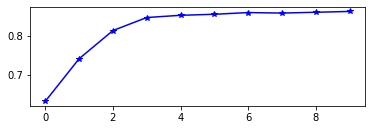

In [2030]:
pyplot.subplot(2,1,1)
pyplot.plot(history['acc'], '-*', color='blue');

###Testing Accuracy of Each Event using Model. Comparing Prediction to y_test.

In [2031]:
lim=0.5
pred = np.argmax(model.predict(w), axis=0)
pred2 = np.argmax(model.predict(w), axis=1)
accuracyList = (y_test*(pred>=lim)+(1-y_test)*(pred<lim)).sum()/len(pred2)
print('-----------------------------')
print('EVENTS         ACCURACY(decimal)')
print(accuracyList)
print('-----------------------------')
#print(np.mean(accuracyList))
#print(len(pred))
#print((y_test*(pred>=lim)+(1-y_test)*(pred<lim)).sum())
print('-----------------------------')
(y_test*(pred>=lim)).sum()

-----------------------------
EVENTS         ACCURACY(decimal)
Rain            0.174807
Snow            0.007712
Fog             0.032905
Thunderstorm    0.029049
Hail            0.001542
Tornado         0.000000
NoEvent         0.548329
dtype: float64
-----------------------------
-----------------------------


Rain             680
Snow              30
Fog              128
Thunderstorm     113
Hail               6
Tornado            0
NoEvent         2133
dtype: int64

#### Judging from the AccuracyList(prediction comparison to y_test) above, seems like the prediction of No Event seems the most likely comapred to every other event. However, Rain is also around 17% likely to happen from our prediction, which is almost 20%. Other events are less likely however Fog and Thunderstorm has around 3% change to happen. With no sample of Tornado in y_test, it determined that tornado is likely to never happen but Hail has a extremely low chance to happen with 0.15% likely to happen. 